# 1 Business Problem

The Canadian banking system continues to rank at the top of the world thanks to the continuous effort to improve our quality control practices. As evident during the 2008 Sub-Prime Mortgage Crisis, Canada was one of the few countries that withstood the Great Recession.

One approach to improve quality control practices is by analyzing the quality of a Bank's business portfolio for each individual business line. For example, a Bank's core business line could be providing construction loan products, and based on the rationale behind each deal for the approval and denial of construction loans, we can also determine the topics in each decision from the rationales. By determining the topics in each decision, we can then perform quality control to ensure all the decisions that were made are in accordance to the Bank's risk appetite and pricing.

With this approach, Banks can improve the quality of their construction loan business from their own decision making standards, and thus improving the overall quality of their business.

However, in order to get this information, the Bank needs to extract topics from hundreds and thousands of data, and then interpret the topics before determining if the decisions that were made meets the Bank's decision making standards, all of which can take a lot of time and resources to complete.
<br>
<br>

**Business Solutions:**

To solve this issue, I have created a "Quality Control System" that learns and extracts topics from a Bank's rationale for decision making. This can then be used as quality control to determine if the decisions that were made are in accordance to the Bank's standards.

We will perform an <u>unsupervised learning</u> algorithm in Topic Modeling, which uses Latent Dirichlet Allocation (LDA) Model, and LDA Mallet (Machine Learning Language Toolkit) Model, on an entire department's decision making rationales.

We will also determine the dominant topic associated to each rationale, as well as determining the rationales for each dominant topics in order to perform quality control analysis.

<u>Note</u>: Although we were given permission to showcase this project, however, we will not showcase any relevant information from the actual dataset for privacy protection.
<br>
<br>

**Benefits:**
- Efficiently determine the main topics of rationale texts in a large dataset
- Improve the quality control of decisions based on the topics that were extracted
- Conveniently determine the topics of each rationale
- Extract detailed information by determining the most relevant rationales for each topic
<br>
<br>

**Robustness:**

To ensure the model performs well, I will take the following steps:
- Run the LDA Model and the LDA Mallet Model to compare the performances of each model
- Run the LDA Mallet Model and optimize the number of topics in the rationales by choosing the optimal model with highest performance

<u>Note</u> that the main different between LDA Model vs. LDA Mallet Model is that, LDA Model uses Variational Bayes method, which is faster, but less precise than LDA Mallet Model which uses Gibbs Sampling. 
<br>
<br>

**Assumption:**
- I have taken data from with a sample size of 511, and assuming that this dataset is sufficient to capture the topics in the rationale
- We're also assuming that the results in this model is applicable in the same way if we were to train an entire population of the rationale dataset with the exception of few parameter tweaks
<br>
<br>

**Future:**

This model is an innovative way to determine key topics embedded in large quantity of texts, and then apply it in a business context to improve a Bank's quality control practices for different business lines. However, since we did not fully showcase all the visualizations and outputs for privacy protection, please refer to "[Employer Reviews using Topic Modeling](https://nbviewer.jupyter.org/github/mick-zhang/Employer-Reviews-using-Topic-Modeling/blob/master/Topic%20Employer%20Github.ipynb?flush_cache=true)" for more detail.

# 2 Data Overview

In [1]:
import pandas as pd
csv = ("audit_rating_banking.csv")
df = pd.read_csv(csv, encoding='latin1') # Solves enocding issue when importing csv
df.head(0)

,Underwriter,Deal Number,Decision,Deal Notes


After importing the data, we see that the "Deal Notes" column is where the rationales are for each deal. This is the column that we are going to use for extracting topics. 

<u>Note</u> that actual data were not shown for privacy protection.

In [2]:
df = df[['Deal Notes']]
df.shape

(511, 1)

In [3]:
df1 = df.copy()
df1["Deal Notes"] = df1["Deal Notes"].apply(lambda x : x.rsplit(maxsplit=len(x.split())-4)[0]) # sets the character limit to 4 words
df1.loc[2:4, ['Deal Notes']]

,Deal Notes
2,Unfortunately I will have
3,Were going to pass
4,Credit: main applicant has


As a expected, we see that there are 511 items in our dataset with 1 data type (text).

I have also wrote a function showcasing a sneak peak of the "Rationale" data (only the first 4 words are shown).

# 3 Data Cleaning

We will use regular expressions to clean out any unfavorable characters in our dataset, and then preview what the data looks like after the cleaning.

In [4]:
data = df['Deal Notes'].values.tolist() # convert to list

# Use Regex to remove all characters except letters and space
import re
data = [re.sub(r'[^a-zA-Z ]+', '', sent) for sent in data]

# Preview the first list of the cleaned data
from pprint import pprint
pprint(data[:1])

<u>Note</u> that output were omitted for privacy protection. However the actual output here are text that has been cleaned with only words and space characters.

# 4 Pre-Processing

With our data now cleaned, the next step is to pre-process our data so that it can used as an input for our LDA model.

We will perform the following:
- Breakdown each sentences into a list of words through Tokenization by using Gensim's `simple_preprocess`
- Additional cleaning by converting text into lowercase, and removing punctuations by using Gensim's `simple_preprocess` once again
- Remove stopwords (words that carry no meaning such as to, the, etc) by using NLTK's `corpus.stopwords`
- Apply Bigram and Trigram model for words that occurs together (ie. warrant_proceeding, there_isnt_enough) by using Gensim's `models.phrases.Phraser`
- Transform words to their root words (ie. walking to walk, mice to mouse) by Lemmatizing the text using `spacy.load(en)` which is Spacy's English dictionary

In [ ]:
# Implement simple_preprocess for Tokenization and additional cleaning
import gensim
from gensim.utils import simple_preprocess 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 
        # deacc=True removes punctuations       
data_words = list(sent_to_words(data))

# Remove stopwords using gensim's simple_preprocess and NLTK's stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use']) # Add additional stop words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
data_words_nostops = remove_stopwords(data_words)


# Create and Apply Bigrams and Trigrams
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram) # Faster way to get a sentence into a trigram/bigram
trigram_mod = gensim.models.phrases.Phraser(trigram)
def make_trigram(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
data_words_trigrams = make_trigram(data_words_nostops)


# Lemmatize the data
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) # Adds English dictionary from Spacy
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        # lemma_ is base form and pos_ is lose part
    return texts_out
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

                                
# Preview the data     
print(data_lemmatized[:1])

<u>Note</u> that output were omitted for privacy protection. However the actual output here are text that are Tokenized, Cleaned (stopwords removed), Lemmatized with applicable bigram and trigrams.

# 5 Prepare Dictionary and Corpus

Now that our data have been cleaned and pre-processed, here are the final steps that we need to implement before our data is ready for LDA input:
- Create a dictionary from our pre-processed data using Gensim's `corpora.Dictionary`
- Create a corpus by applying "term frequency" (word count) to our "pre-processed data dictionary" using Gensim's `.doc2bow`

In [11]:
import gensim.corpora as corpora
id2word = corpora.Dictionary(data_lemmatized)      # Create dictionary
texts = data_lemmatized                            # Create corpus
corpus = [id2word.doc2bow(text) for text in texts] # Apply Term Frequency
print(corpus[:1])                                  # Preview the data

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]]


We can see that our corpus is a list of every word in an index form followed by count frequency.

In [12]:
id2word[0]

'brother'

We can also see the actual word of each index by calling the index from our pre-processed data dictionary.

In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

Lastly, we can see the list of every word in actual word (instead of index form) followed by their count frequency using a simple `for` loop.

<u>Note</u> that output were omitted for privacy protection. However the actual output here are a list of text showing words with their corresponding count frequency.

Now that we have created our dictionary and corpus, we can feed the data into our LDA Model.

# 6 LDA Model

**Latent (hidden) Dirichlet Allocation** is a generative probabilistic model of a documents (composites) made up of words (parts). The model is based on the probability of words when selecting (sampling) topics (category), and the probability of topics when selecting a document.

Essentially, we are extracting topics in documents by looking at the probability of words to determine the topics, and then the probability of topics to determine the documents. 

There are two LDA algorithms. The **Variational Bayes** is used by Gensim's **LDA Model**, while **Gibb's Sampling** is used by **LDA Mallet Model** using Gensim's Wrapper package.

Here is the general overview of Variational Bayes and Gibbs Sampling:
- **Variational Bayes**
    - Sampling the variations between, and within each word (part or variable) to determine which topic it belongs to (but some variations cannot be explained)
    - Fast but less accurate
- **Gibb's Sampling (Markov Chain Monte Carlos)**
    - Sampling one variable at a time, conditional upon all other variables
    - Slow but more accurate

In [ ]:
# Build LDA Model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics = 9, random_state = 100,
                                            update_every = 1, chunksize = 100, passes = 10, alpha = 'auto',
                                            per_word_topics=True) # Here we selected 9 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

After building the LDA Model using Gensim, we display the 10 topics in our document along with the top 10 keywords and their corresponding weights that makes up each topic.

<u>Note</u> that output were omitted for privacy protection.. However the actual output is a list of the 9 topics, and each topic shows the top 10 keywords and their corresponding weights that makes up the topic.

# 7 LDA Model Performance

In [15]:
# Compute perplexity
print('Perplexity: ', lda_model.log_perplexity(corpus))

# Compute coherence score
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)


Perplexity:  -6.876382108603263

Coherence Score:  0.4136469957174781


In order to determine the accuracy of the topics that we used, we will compute the Perplexity Score and the Coherence Score. The Perplexity score measures how well the LDA Model predicts the sample (the lower the perplexity score, the better the model predicts). The Coherence score measures the quality of the topics that were learned (the higher the coherence score, the higher the quality of the learned topics).

Here we see a **Perplexity score of -6.87** (negative due to log space), and **Coherence score of 0.41**. 

<u>Note</u>: We will use the Coherence score moving forward, since we want to optimizing the number of topics in our documents.

## 7.1 Visualize LDA Model

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # Hides all future warnings
import pyLDAvis
import pyLDAvis.gensim 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

We are using pyLDAvis to visualize our topics. 

For interpretation of pyLDAvis:
- Each bubble represents a topic
- The larger the bubble, the more prevalent the topic will be
- A good topic model has fairly big, non-overlapping bubbles scattered through the chart (instead of being clustered in one quadrant)
- Red highlight: Salient keywords that form the topics (most notable keywords)

<u>Note</u> that output were omitted for privacy protection.

# 8 LDA Mallet Model

Now that we have completed our Topic Modeling using "Variational Bayes" algorithm from Gensim's LDA, we will now explore Mallet's LDA (which is more accurate but slower) using Gibb's Sampling (Markov Chain Monte Carlos) under Gensim's Wrapper package.

Mallet's LDA Model is more accurate, since it utilizes Gibb's Sampling by sampling one variable at a time conditional upon all other variables.

In [17]:
import os
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME':r'/Users/Mick/Desktop/mallet/'}) # Set environment
mallet_path = '/Users/Mick/Desktop/mallet/bin/mallet'             # Update this path

# Build the LDA Mallet Model
ldamallet = LdaMallet(mallet_path,corpus=corpus,num_topics=9,id2word=id2word) # Here we selected 9 topics again
pprint(ldamallet.show_topics(formatted=False))

After building the LDA Mallet Model using Gensim's Wrapper package, here we see our 7 new topics in the document along with the top 10 keywords and their corresponding weights that makes up each topic.

<u>Note</u> that output were omitted for privacy protection. However the actual output is a list of the 9 topics, and each topic shows the top 10 keywords and their corresponding weights that makes up the topic.

## 8.1 LDA Mallet Model Performance

In [20]:
# Compute coherence score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence="c_v")
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.4102038587308669


Here we see the Coherence Score for our **LDA Mallet Model** is showing **0.41** which is similar to the LDA Model above. Also, given that we are now using a more accurate model from **Gibb's Sampling**, and combined with the purpose of the Coherence Score was to measure the quality of the topics that were learned, then our next step is to improve the actual Coherence Score, which will ultimately improve the overall quality of the topics learned.

To improve the quality of the topics learned, we need to find the optimal number of topics in our document, and once we find the optimal number of topics in our document, then our Coherence Score will be optimized, since all the topics in the document are extracted accordingly without redundancy.

# 9 Finding the Optimal Number of Topics for LDA Mallet Model

We will use the following function to run our **LDA Mallet Model**:

    compute_coherence_values
    
<u>Note</u>: We will trained our model to find topics between the range of 2 to 12 topics with an interval of 1.

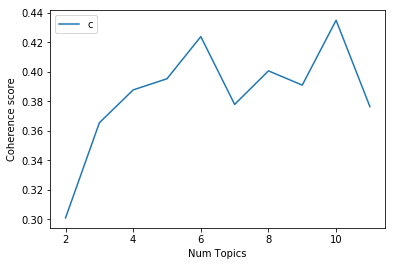

In [24]:
# Compute a list of LDA Mallet Models and corresponding Coherence Values
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence()) 
    return model_list, coherence_values
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized,
                                                        start=2, limit=12, step=1)

# Visualize the optimal LDA Mallet Model
import matplotlib.pyplot as plt
%matplotlib inline
limit=12; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [25]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print('Num Topics =', m, ' has Coherence Value of', round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3009
Num Topics = 3  has Coherence Value of 0.3654
Num Topics = 4  has Coherence Value of 0.3877
Num Topics = 5  has Coherence Value of 0.3953
Num Topics = 6  has Coherence Value of 0.4238
Num Topics = 7  has Coherence Value of 0.3779
Num Topics = 8  has Coherence Value of 0.4006
Num Topics = 9  has Coherence Value of 0.391
Num Topics = 10  has Coherence Value of 0.4349
Num Topics = 11  has Coherence Value of 0.3763


With our models trained, and the performances visualized, we can see that the optimal number of topics here is **10 topics** with a Coherence Score of **0.43** which is slightly higher than our previous results at 0.41. However, we can also see that the model with a coherence score of 0.43 is also the highest scoring model, which implies that there are a total 10 dominant topics in this document.

We will proceed and select our final model using 10 topics.

In [ ]:
# Select the model with highest coherence value and print the topics
optimal_model = model_list[8]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10)) # Set num_words parament to show 10 words per each topic

By using our **Optimal LDA Mallet Model** using Gensim's Wrapper package, we displayed the 10 topics in our document along with the top 10 keywords and their corresponding weights that makes up each topic.

<u>Note</u> that output were omitted for privacy protection. However the actual output is a list of the 10 topics, and each topic shows the top 10 keywords and their corresponding weights that makes up the topic.

## 9.1 Visual the Optimal LDA Mallet Model

In [ ]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
topics = optimal_model.show_topics(formatted=False)
fig, axes = plt.subplots(2, 5, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Here we also visualized the 10 topics in our document along with the top 10 keywords. Each keyword's corresponding weights  are shown by the size of the text.

<u>Note</u> that output were omitted for privacy protection.

# 10 Analysis

Now that our **Optimal Model** is constructed, we will apply the model and determine the following:
- Determine the dominant topics for each document
- Determine the most relevant document for each of the 10 dominant topics
- Determine the distribution of documents contributed to each of the 10 dominant topics

## 10.1 Finding topics for each document

In [ ]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()
    # Get dominant topic in each document
    for i, row in enumerate(ldamodel[corpus]):                   
        row = sorted(row, key=lambda x: (x[1]), reverse=True)        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:                                           
                wp = ldamodel.show_topic(topic_num)              
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4),
                                                                  topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'] # Create dataframe title
    # Add original text to the end of the output (recall that texts = data_lemmatized)
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)    
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Document']
df_dominant_topic.head(10)

<u>Note</u> that output were omitted for privacy protection. However the actual output is a list of the first 10 document with corresponding dominant topics attached.

## 10.2 Finding documents for each topic

In [ ]:
# Group top 10 documents for the 10 dominant topic
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic') 
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Document"]
sent_topics_sorteddf_mallet 

<u>Note</u> that output were omitted for privacy protection. However the actual output is a list of most relevant documents for each of the 10 dominant topics.

## 10.3 Document distribution across Topics

In [30]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_num_keywords = {'Topic_Num': pd.Series([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0])}
topic_num_keywords = pd.DataFrame(topic_num_keywords)
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
df_dominant_topics.reset_index(drop=True, inplace=True)
df_dominant_topics.columns = ['Dominant Topic', 'Num_Document', 'Perc_Document']
df_dominant_topics

,Dominant Topic,Num_Document,Perc_Document
0,0.0,27,0.0528
1,1.0,27,0.0528
2,2.0,23,0.0450
3,3.0,96,0.1879
4,4.0,55,0.1076
5,5.0,43,0.0841
6,6.0,26,0.0509
7,7.0,42,0.0822
8,8.0,44,0.0861
9,9.0,128,0.2505


Here we see the number of documents and the percentage of overall documents that contributes to each of the 10 dominant topics.

# 11 Answering the Questions

Based on our modeling above, we were able to use a very accurate model from Gibb's Sampling, and further optimize the model by finding the optimal number of dominant topics without redundancy.

As a result, we are now able to see the 10 dominant topics that were extracted from our dataset. Furthermore, we are also able to see the dominant topic for each of the 511 documents, and determine the most relevant document for each dominant topics.

With the in-depth analysis of each individual topics and documents above, the Bank can now use this approach as a "Quality Control System" to learn the topics from their rationales in decision making, and then determine if the rationales that were made are in accordance to the Bank's standards for quality control.